<a href="https://colab.research.google.com/github/hsnaydos11/Classifying-MNIST-Dataset-with-Convolutional-Neural-Networks/blob/main/CNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gerekli bütün açıklamalar ve matematiksel hesaplamalar gönderilecek dosyada mevcuttur.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image

Veri Setini ve Test setlerini Yükleme ve *Dönüştürme*

In [ ]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 36139059.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93396834.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45549329.83it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Burdaki cnn modeli genel hesaplamayı yapmak için

In [ ]:
class SimpleCNN(nn.Module):
   def __init__(self):
      super(SimpleCNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.fc1 = nn.Linear(64 * 5 * 5, 128)
      self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 64 * 5 * 5)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x


BURADAKİ CNN MODELİ KATMANLARDAKİ HESAPLAMALARIN GÖRSELLEŞTİRLMESİ İÇİN YAPILMIŞTIR.

In [ ]:

class SimpleCNN_visual(nn.Module):
    def __init__(self):
        super(SimpleCNN_visual, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        conv1_out = self.pool(F.relu(self.conv1(x)))
        conv2_out = self.pool(F.relu(self.conv2(conv1_out)))
        x = conv2_out.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return conv1_out, F.relu(conv1_out), conv2_out, F.softmax(x, dim=1)

Modeli İnşa Etme ve Optimizasyon Ayarları

In [ ]:
net = SimpleCNN()
net1 = SimpleCNN_visual()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

Eğitim ve Doğruluk Hesaplama Fonksiyonu

In [ ]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Eğitim ve Doğruluk Listeleri
loss_list = []
accuracy_list = []

MNIST verisetinden rastgele bir veri almak için kullanılır.

In [ ]:

images, labels = next(iter(trainloader))

MNIST verisetinden alınan verileri katmanlardaki işlemlerden sonra nasıl göründüğünü göstermek için kullanılır.

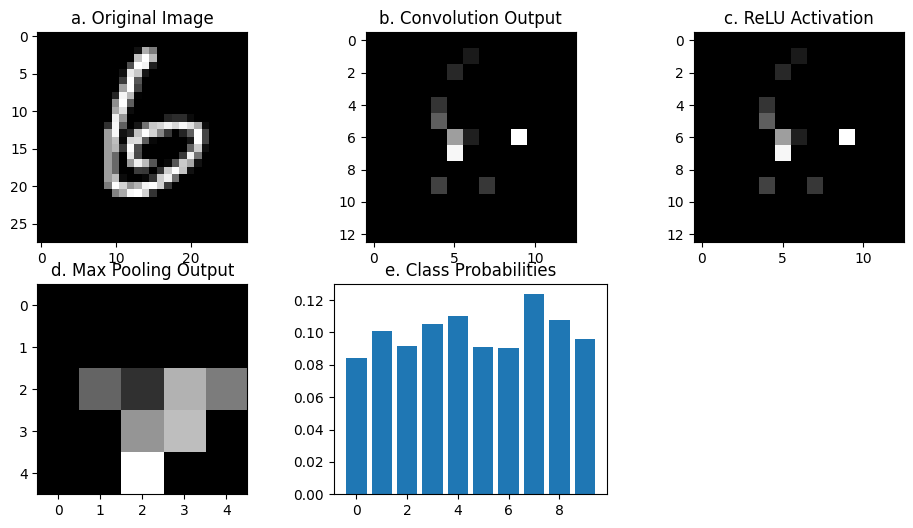

In [ ]:
# Resmin sayısal matrise dönüştürülmesi
image_matrix = images[0][0].detach().numpy()

# Evrişim katmanları ve boyut değişiklikleri
conv1_out, relu_conv1_out, pooled1_out, class_prob = net1(images)

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image_matrix, cmap='gray')
plt.title("a. Original Image")

plt.subplot(2, 3, 2)
plt.imshow(conv1_out[0][0].detach().numpy(), cmap='gray')
plt.title("b. Convolution Output")

plt.subplot(2, 3, 3)
plt.imshow(relu_conv1_out[0][0].detach().numpy(), cmap='gray')
plt.title("c. ReLU Activation")

plt.subplot(2, 3, 4)
plt.imshow(pooled1_out[0][0].detach().numpy(), cmap='gray')
plt.title("d. Max Pooling Output")

plt.subplot(2, 3, 5)
plt.bar(range(10), class_prob[0].detach().numpy())
plt.title("e. Class Probabilities")

plt.show()

CNN modelini test etmek için gerekli işlemler

In [ ]:
for epoch in range(5):  # 5 epoch için eğitim
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Her epoch sonunda kayıp ve doğruluk hesapla
    loss_list.append(running_loss / len(trainloader))
    accuracy = calculate_accuracy(net, trainloader)
    accuracy_list.append(accuracy)

    print('[%d] loss: %.3f, accuracy: %.3f' % (epoch + 1, running_loss / len(trainloader), accuracy))

    # Her epoch başında running_loss ve accuracy sıfırlanır
    running_loss = 0.0

print('Eğitim tamamlandı!')

[1] loss: 0.166, accuracy: 0.985
[2] loss: 0.046, accuracy: 0.991
[3] loss: 0.032, accuracy: 0.991
[4] loss: 0.023, accuracy: 0.996
[5] loss: 0.017, accuracy: 0.995
Eğitim tamamlandı!


Bütün epochlardan sonraki loss ve accuracy değerlerini ölçmek için kullanılır.

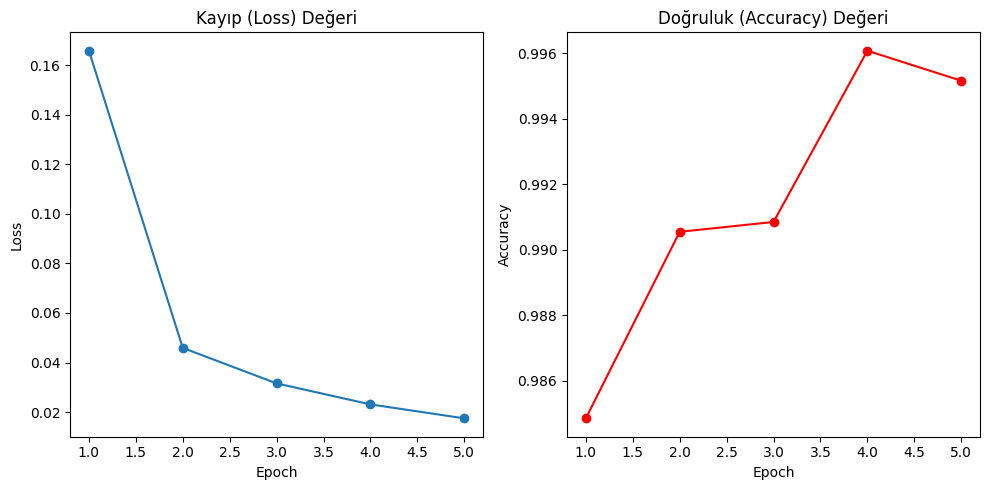

In [ ]:
epochs = range(1, len(loss_list) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, marker='o')
plt.title('Kayıp (Loss) Değeri')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_list, marker='o', color='r')
plt.title('Doğruluk (Accuracy) Değeri')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Modelin Performansını Test Verisi Üzerinde Değerlendirme

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Test veri seti üzerinde doğruluk oranı: {:.2%}'.format(accuracy))

evaluate_model(net, testloader)

Test veri seti üzerinde doğruluk oranı: 99.04%


Confusion matrix oluşturulması sağlanır.

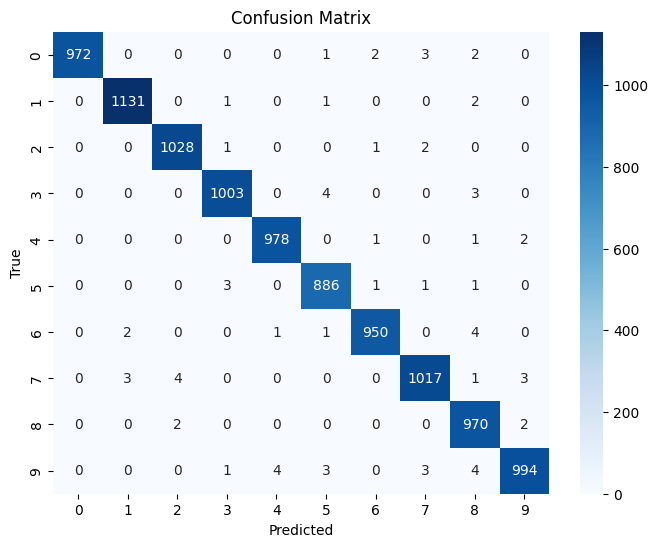

In [ ]:
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Modeli değerlendirme moduna al

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Sınıf isimlerini tanımla (MNIST örneğinde 0'dan 9'a kadar rakamlar)
class_names = [str(i) for i in range(10)]

# Modelin karmaşıklık matrisini çiz
plot_confusion_matrix(net, testloader, class_names)


Verilerde oluşturulan sınıfların her biri için precision, recall ve F1-score değerlerini ölçmek için kullanılır.

In [ ]:
def calculate_per_class_metrics(model, dataloader, class_names):
    model.eval()  # Modeli değerlendirme moduna al

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Precision, recall, F1-score ve support değerlerini hesapla
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, labels=range(len(class_names)))

    # Sonuçları ekrana yazdır
    print('{:<15} {:<15} {:<15} {:<15}'.format('Class', 'Precision', 'Recall', 'F1-Score'))
    for i in range(len(class_names)):
        print('{:<15} {:<15.2f} {:<15.2f} {:<15.2f}'.format(class_names[i], precision[i], recall[i], f1[i]))

# Sınıf isimlerini tanımla (MNIST örneğinde 0'dan 9'a kadar rakamlar)
class_names = [str(i) for i in range(10)]

# Her sınıf için precision, recall ve F1-score'ları hesapla ve göster
calculate_per_class_metrics(net, testloader, class_names)


Class           Precision       Recall          F1-Score       
0               1.00            0.99            1.00           
1               1.00            1.00            1.00           
2               0.99            1.00            1.00           
3               0.99            0.99            0.99           
4               0.99            1.00            1.00           
5               0.99            0.99            0.99           
6               0.99            0.99            0.99           
7               0.99            0.99            0.99           
8               0.98            1.00            0.99           
9               0.99            0.99            0.99           
